**Chapter 07 – Natural Language Processing with RNNs and Attention**

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#if not tf.test.is_gpu_available():
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

#def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#    print("Saving figure", fig_id)
#    if tight_layout:
#        plt.tight_layout()
#    plt.savefig(path, format=fig_extension, dpi=resolution)

# Char-RNN

## Splitting a sequence into batches of shuffled windows

For example, let us split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps)) #`flat_map`: use if we want to keep the order of our dataset
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:])) # if A=[1,2,3,4]; then A[:-1]=> [1, 2, 3]; 
                                                                                            # and A[1:] => [2, 3, 4]
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Loading the Data and Preparing the Dataset

First, let us download all of Shakespeare’s work, using - 
* Keras’s handy get_file() function and 
* downloading the data from Andrej Karpathy’s Char-RNN project:

In [5]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [8]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [29]:
"".join(sorted(set(shakespeare_text.lower()))) # 13 + 26 = 39 different characters

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

**Next, we must encode every character as an integer**:
First we need to fit a tokenizer (using Keras’s `Tokenizer` class) to the text: 
* It will find all the characters used in the text and map each of them to a different character ID, from 1 to the number of distinct characters (it does not start at 0, so we can use that value for masking, as we will see later in this chapter):

In [9]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

We set `char_level=True` to get character-level encoding rather than the default word-level encoding. 
* Note that this tokenizer converts the text to lowercase by default (but we can set `lower=False` if you do not want that). 
* Now the tokenizer can encode a sentence (or a list of sentences) to a list of character IDs and back, and it tells us how many distinct characters there are and the total number of characters in the text:

In [31]:
tokenizer.texts_to_sequences(["First"]) # F => 20, i => 6, ....

[[20, 6, 9, 8, 3]]

In [32]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [33]:
max_id = len(tokenizer.word_index) # number of distinct characters => max_id = 39 in this case.
dataset_size = tokenizer.document_count # total number of characters
dataset_size

1115394

Let us encode the full text so each character is represented by its ID (we subtract 1 to get IDs from 0 to 38, rather than from 1 to 39):

In [34]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
[encoded]

[array([19,  5,  8, ..., 20, 26, 10])]

In [35]:
len(encoded)

1115394

### How to Split a Sequential Dataset
Let us take the first 90% of the text for the training set (keeping the rest for the validation set and the test set), and create a `tf.data.Dataset` that will return each character one by one from this set:

In [36]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

### Chopping the Sequential Dataset into Multiple Windows
Let us call the `window()` method to create a dataset of short text windows:

In [37]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

You can try tuning `n_steps`: 
   * it is easier to train RNNs on shorter input sequences, 
   * but of course the RNN will not be able to learn any pattern longer than n_steps, 
   * so don’t make it too small.

By default, the `window()` method creates nonoverlapping windows, but to get the largest possible training set we use `shift=1` so that the first window contains characters 0 to 100, the second contains characters 1 to 101, and so on. 

To ensure that all windows are exactly 101 characters long (which will allow us to create batches without having to do any padding), we set `drop_remainder=True` (otherwise the last 100 windows will contain 100 characters, 99 characters, and so on down to 1 character).

#### flat_map:
The `window()` method creates a dataset that contains windows, each of which is also represented as a dataset. 
 * It’s a nested dataset, analogous to a list of lists. This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them). 

However, we cannot use a nested dataset directly for training, as our model will expect tensors as input, not datasets. So, we must call the `flat_map()` method: 
* it converts a nested dataset into a flat dataset (one that does not contain datasets). For example, suppose {1, 2, 3} represents a dataset containing the sequence of tensors 1, 2, and 3. If you flatten the nested dataset {{1, 2}, {3, 4, 5, 6}}, you get back the flat dataset {1, 2, 3, 4, 5, 6}. Moreover, the flat_map() method takes a function as an argument, which allows you to transform each dataset in the nested dataset before flattening. 
* For example, if you pass the function lambda ds: ds.batch(2) to flat_map(), then it will transform the nested dataset {{1, 2}, {3, 4, 5, 6}} into the flat dataset {[1, 2], [3, 4], [5, 6]}: 
* it’s a dataset of tensors of size 2. 

With that in mind, we are ready to flatten our dataset:

In [38]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

Notice that we call `batch(window_length)` on each window: 
* since all windows have exactly that length, we will get a single tensor for each of them. Now the dataset contains consecutive windows of 101 characters each. Since Gradient Descent works best when the instances in the training set are independent and identically distributed (iid), we need to shuffle these windows. 

Then we can batch the windows and separate the inputs (the first 100 characters) from the target (the last character):

**Figure 1** summarizes the dataset preparation steps discussed so far (showing windows of length 11 rather than 101, and a batch size of 3 instead of 32).


<img src="./images/Figure_01.png" width="700" border="1">

**Fig. 1**: Preparing a dataset of shuffled windows.

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

In [40]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

Categorical input features should generally be encoded, usually as one-hot vectors or as embeddings. 

Here, we will encode each character using a one-hot vector because there are fairly few distinct characters (only 39):

In [41]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [42]:
X_batch

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[ 0,  1,  2,  3],
       [ 8,  9, 10, 11],
       [10, 11, 12, 13]])>

In [43]:
Y_batch

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[ 1,  2,  3,  4],
       [ 9, 10, 11, 12],
       [11, 12, 13, 14]])>

In [44]:
a=tf.one_hot(X_batch, depth=max_id)
a

<tf.Tensor: shape=(3, 4, 39), dtype=float32, numpy=
array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0

Finally, we just need to add prefetching:

In [55]:
dataset = dataset.prefetch(1)

In [19]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Creating and Training the Model

To predict the next character based on the previous 100 characters, we can use an RNN with 2 `GRU` layers of 128 units each and 20% dropout on both the inputs (`dropout`) and the hidden states (`recurrent_dropout`). 
* We can tweak these hyperparameters later, if needed. 
* The output layer is a time-distributed Dense layer. 
    * Here, this layer must have 39 units (max_id) because there are 39 distinct characters in the text, and we want to output a probability for each possible character (at each time step). 
    
The output probabilities should sum up to 1 at each time step, so we apply the softmax activation function to the outputs of the `Dense` layer. 

We can then compile this model, using the `"sparse_categorical_crossentropy"` loss and an Adam optimizer. 

Finally, we are ready to train the model for several epochs (this may take many hours, depending on our hardware):

In [20]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     # no dropout in stateful RNN (https://github.com/ageron/handson-ml2/issues/32)
                     # dropout=0.2, recurrent_dropout=0.2,
                     ),
    keras.layers.GRU(128, return_sequences=True,
                     # dropout=0.2, recurrent_dropout=0.2
                    ),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Train for 31370 steps
Epoch 1/10
31370/31370 [==============================] - 6549s 209ms/step - loss: 0.9543
Epoch 2/10
31370/31370 [==============================] - 6003s 191ms/step - loss: 0.9544
Epoch 3/10
31370/31370 [==============================] - 5845s 186ms/step - loss: 1.0189
Epoch 4/10
31370/31370 [==============================] - 5557s 177ms/step - loss: 1.0633
Epoch 5/10
31370/31370 [==============================] - 5583s 178ms/step - loss: 1.1040
Epoch 6/10
31370/31370 [==============================] - 5571s 178ms/step - loss: 1.1310
Epoch 7/10
31370/31370 [==============================] - 5582s 178ms/step - loss: 1.1584
Epoch 8/10
31370/31370 [==============================] - 20297s 647ms/step - loss: 1.1947
Epoch 9/10
31370/31370 [==============================] - 6742s 215ms/step - loss: 1.2087
Epoch 10/10
31370/31370 [==============================] - 6568s 209ms/step - loss: 1.2329


## Using the Model to Generate Text

Now we have a model that can predict the next character in text written by Shakespeare. 

To feed it some text, we first need to preprocess it like we did earlier, so let us create a little function for this:

In [49]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

Now let us use the model to predict the next letter in some text:

In [22]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

Success! The model guessed right. Now let us use this model to generate new text.

### Generating Fake Shakespearean Text
To generate new text using the Char-RNN model, we could feed it some text, make the model predict the most likely next letter, add it at the end of the text, then give the extended text to the model to guess the next letter, and so on. But in practice this often leads to the same words being repeated over and over again.

Instead, **we can pick the next character randomly, with a probability equal to the estimated probability**, using TensorFlow’s `tf.random.categorical()` function. 

This will generate more diverse and interesting text. The `categorical()` function samples random **class indices**, given the **class log probabilities** (logits). 

To have more control over the diversity of the generated text, we can divide the logits by a number called the *temperature*, which we can tweak as we wish: 
* **a temperature close to 0 will favor the highprobability characters**, while **a very high temperature will give all characters an equal probability**. 

The following `next_char()` function uses this approach to pick the next character to add to the input text:

In [47]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0]],
      dtype=int64)

In [48]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [25]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

Next, we can write a small function that will repeatedly call `next_char()` to get the next character and append it to the given text:

In [26]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

We are now ready to generate some text! 

Let us try with different temperatures:

In [27]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2)) # "t" is the first character to start with.

the belly and will not signior baptista make her li


In [28]:
print(complete_text("t", temperature=1))

thumblear you whither's gi-a chays advise ye will c


In [29]:
print(complete_text("t", temperature=2))

th he wleven repjaitwer you 'er griathemspectmen's;


## Stateful RNN

First, note that a stateful RNN only makes sense **if each input sequence in a batch starts exactly where the corresponding sequence** in the previous batch left off. 

* So the first thing we need to do to build a stateful RNN is to use **sequential and nonoverlapping** input sequences (rather than the shuffled and overlapping sequences we used to train stateless RNNs). 


* When creating the Dataset, we **must therefore use `shift=n_steps` (instead of `shift`=1)** when calling the `window()` method. 


* Moreover, we must obviously **not call** the `shuffle()` method. 


* Unfortunately, **batching is much harder** when preparing a dataset for a stateful RNN than it is for a stateless RNN.


* Indeed, if we were to call batch(32), then 32 consecutive windows would be put in the same batch, and the following batch would not continue each of these window where it left off. 


* The first batch would contain windows 1 to 32 and the second batch would contain windows 33 to 64, so if you consider, say, the first window of each batch (i.e., windows 1 and 33), you can see that they are not consecutive. 

The simplest solution to this problem is to just use “batches” containing a single window:

In [30]:
tf.random.set_seed(42)

In [31]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

**Figure 2** summarizes the first steps.

<img src="./images/Figure_02.png" width="700" border="1">

**Fig. 2**: Preparing a dataset of consecutive sequence fragments for a stateful RNN.

Batching is **harder, but it is not impossible**. 
* For example, we could chop Shakespeare’s text into 32 texts of equal length,  
* create one dataset of consecutive input sequences for each of them, and 
* finally use `tf.train.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))` to create proper consecutive batches, where the $ n^{th} $ input sequence in a batch starts off exactly where the $ n^{th} $ input sequence ended in the previous batch:

In [32]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

Now let’s create the stateful RNN. 
* First, we **need to set `stateful=True`** when creating every recurrent layer. 

* Second, the stateful RNN **needs to know the batch size** (since it will preserve a state for each input sequence in the batch), so we must set the `batch_input_shape` argument in the first layer. 

Note that we can leave the second dimension unspecified, since the inputs could have any length:

In [33]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

At the **end of each epoch**, we need to reset the states before we go back to the **beginning of the text**. For this, we can use a small callback:

In [34]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

And now we can compile and fit the model (for more epochs, because each epoch is much shorter than earlier, and there is only one instance per batch):

In [35]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                   callbacks=[ResetStatesCallback()])

Train for 313 steps
Epoch 1/50
313/313 [==============================] - 94s 300ms/step - loss: 2.6224
Epoch 2/50
313/313 [==============================] - 89s 284ms/step - loss: 2.2280
Epoch 3/50
313/313 [==============================] - 87s 278ms/step - loss: 2.1504
Epoch 4/50
313/313 [==============================] - 90s 286ms/step - loss: 2.4703
Epoch 5/50
313/313 [==============================] - 89s 286ms/step - loss: 2.3564
Epoch 6/50
313/313 [==============================] - 86s 275ms/step - loss: 2.2296
Epoch 7/50
313/313 [==============================] - 86s 275ms/step - loss: 2.1407
Epoch 8/50
313/313 [==============================] - 94s 299ms/step - loss: 2.0708
Epoch 9/50
313/313 [==============================] - 94s 301ms/step - loss: 2.0455
Epoch 10/50
313/313 [==============================] - 89s 284ms/step - loss: 2.0043
Epoch 11/50
313/313 [==============================] - 87s 278ms/step - loss: 1.9645
Epoch 12/50
313/313 [==============================] -

After this model is trained, it will only be possible **to use it to make predictions for batches of the same size** as were used during training. 

To **avoid this restriction (i.e., the model with different batch sizes), we need to create a stateless copy**. We can get rid of dropout since it is only used during training:

In [36]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [37]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [38]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [39]:
tf.random.set_seed(42)

print(complete_text("t"))

tor'd your confuld darce;
and sip did much bruet of


Now that we have built a character-level model, it’s time to look at word-level models and tackle a common natural language processing task: sentiment analysis. 

In the process we will learn how to handle sequences of variable lengths using masking (**Masking** is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data).

# Sentiment Analysis

IMDb reviews dataset is consists of 50,000 movie reviews in English (25,000 for training, 25,000 for testing) extracted from the famous Internet Movie Database, along with a simple binary target for each review indicating whether it is negative (0) or positive (1). 

IMDb reviews dataset is popular for good reasons: it is simple enough to be tackled on a laptop in a reasonable amount of time, but challenging enough to be fun and rewarding. 

In [40]:
tf.random.set_seed(42)

You can load the IMDB dataset easily - Keras provides a simple function to load it:

In [41]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 7s 0us/step


In [42]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

Where are the movie reviews? 

Well, as we can see, the dataset is already preprocessed for us: 
   * `X_train` consists of a list of reviews, each of which is represented as a NumPy array of integers, where each integer represents a word. 
   * All punctuation was removed, and then words were converted to lowercase, split by spaces, and 
   * finally indexed by frequency (so **low integers correspond to frequent words**). 
   * The integers 0, 1, and 2 are special: 
       * they represent the **padding** (pad) token, 
       * the **start-of-sequence** (sos) token, and 
       * **unknown words** (unk), respectively. 


If we want to visualize a review, we can decode it like this:

In [43]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 1s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In a real project, we will have to preprocess the text ourselves. 

We can do that using the same `Tokenizer` class we used earlier, but this time setting `char_level=False` (which is the default). 


When encoding words, it filters out a lot of characters, including most punctuation, line breaks, and tabs (but we can change this by setting the filters argument). 


Most importantly, it uses spaces to identify word boundaries. 

This is OK for English and many other scripts (written languages) that use spaces between words, but not all scripts use spaces this way: 

* Chinese does not use spaces between words, Vietnamese uses spaces even within words, and languages such as German often attach multiple words together, without spaces. 

* Even in English, spaces are not always the best way to tokenize text: think of “San Francisco” or “#ILoveDeepLearning.”


[See Slides, __page #10-11__]

If we want to deploy our model to a **mobile device** or a **web browser**, and we don’t want to have to write a different preprocessing function every time, then we will want to handle preprocessing using only TensorFlow operations, so it can be included in the model itself. 

Let us see how. First, let us load the original IMDb reviews, as text (byte strings), using TensorFlow Datasets:

In [44]:
import tensorflow_datasets as tfds  # if code fails, run: conda install -c anaconda tensorflow-datasets

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to C:\Users\tamjid\tensorflow_datasets\imdb_reviews\plain_text\0.1.0. Subsequent calls will reuse this data.


In [45]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [46]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [47]:
train_size, test_size

(25000, 25000)

In [48]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: I saw this film on True Movies (which automatically made me sceptical) but actually - it was good. Why? Not because of the amazing plot twists or breathtaking dialogue (of which there is little) but b ...
Label: 1 = Positive

Review: While watching this movie I was frustrated and distracted and by the end, I wanted to give the movie a solid 4 or 5. I thought the animation was random and all over the place and there was too much go ...
Label: 1 = Positive



Next, let us write the preprocessing function:

In [49]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

It starts by truncating the reviews, keeping only the first 300 characters of each: 
* this will speed up training, and it won’t impact performance too much because we can generally tell whether a review is positive or not in the first sentence or two. 
* Then it uses ***regular expressions*** to replace `<br />` tags with spaces, and to replace any characters other than letters and quotes with spaces. 
    * For example, the text `"Well, I can't<br />"` will become `"Well I can't"`. 

Finally, the `preprocess()` function splits the reviews by the spaces, which returns a ragged tensor, and it converts this ragged tensor to a dense tensor, padding all reviews with the padding token `"<pad>"` so that they all have the same length.

In [50]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 59), dtype=string, numpy=
 array([[b'I', b'saw', b'this', b'film', b'on', b'True', b'Movies',
         b'which', b'automatically', b'made', b'me', b'sceptical', b'but',
         b'actually', b'it', b'was', b'good', b'Why', b'Not', b'because',
         b'of', b'the', b'amazing', b'plot', b'twists', b'or',
         b'breathtaking', b'dialogue', b'of', b'which', b'there', b'is',
         b'little', b'but', b'because', b'actually', b'despite', b'what',
         b'people', b'say', b'I', b'thought', b'the', b'film', b'was',
         b'accurate', b'in', b"it's", b'depiction', b'of', b'teenag',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>'],
        [b'While', b'watching', b'this', b'movie', b'I', b'was',
         b'frustrated', b'and', b'distracted', b'and', b'by', b'the',
         b'end', b'I', b'wanted', b'to', b'give', b'the', b'movie', b'a',
         b'solid', b'or', b'I', b'thought', b'the', b'animation', b'was',
 

Next, we need to construct the vocabulary. 

* This requires going through the whole training set once, applying our `preprocess()` function, and using a `Counter` to count the number of occurrences of each word:

In [51]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

Let us look at the three most common words:

In [52]:
vocabulary.most_common()[:3]

[(b'<pad>', 215501), (b'the', 61137), (b'a', 38564)]

In [53]:
len(vocabulary)

53893

Great! We probably don’t need our model to know all the words in the dictionary to get good performance, though, so let us truncate the vocabulary, keeping only the 10,000 most common words:

In [54]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [55]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


Now we need to add a preprocessing step to replace each word with its ID (i.e., its index in the vocabulary). 

We will create a lookup table for this, using 1,000 out-of-vocabulary (oov) buckets:

In [56]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

We can then use this table to look up the IDs of a few words:

In [57]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]], dtype=int64)>

Note that the words “this,” “movie,” and “was” were found in the table, so their IDs are lower than 10,000, 

while the word “faaaaaantastic” was not found, so it was mapped to one of the oov buckets, with an ID greater than or equal to 10,000.

**TF Transform** provides some useful functions to handle such vocabularies. 

For example, check out the `tft.compute_and_apply_vocabulary()` function: 
* it will go through the dataset to find all distinct words and build the vocabulary, and it will generate the TF operations required to encode each word using this vocabulary.

Now we are ready to create the final training set. We batch the reviews, then convert them to short sequences of words using the `preprocess()` function, then encode these words using a simple `encode_words()` function that uses the table we just built, and finally prefetch the next batch:

In [59]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [60]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11 1738 ...    0    0    0]
 [   6  338 3986 ...    0    0    0]
 [  74   43  599 ...    0    0    0]
 ...
 [  22    7  415 ...    0    0    0]
 [   6  145    2 ...  468    0    0]
 [   6   11  116 ...    0    0    0]], shape=(32, 64), dtype=int64)
tf.Tensor([1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1], shape=(32,), dtype=int64)


At last we can create the model and train it:

In [61]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, 
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 123s 158ms/step - loss: 0.5388 - accuracy: 0.7195
Epoch 2/5
781/781 [==============================] - 123s 157ms/step - loss: 0.3422 - accuracy: 0.8586
Epoch 3/5
781/781 [==============================] - 145s 186ms/step - loss: 0.1827 - accuracy: 0.9346
Epoch 4/5
781/781 [==============================] - 172s 221ms/step - loss: 0.1101 - accuracy: 0.9616
Epoch 5/5
781/781 [==============================] - 173s 221ms/step - loss: 0.0938 - accuracy: 0.9670


* The first layer is an Embedding layer, which will convert word IDs into embeddings. 

* The embedding matrix needs to have one row per word ID (`vocab_size + num_oov_buckets`) and one column per embedding dimension (this example uses 128 dimensions, but this is a hyperparameter you could tune). 

* Whereas the inputs of the model will be 2D tensors of shape [*batch size, time steps*], the output of the `Embedding` layer will be a 3D tensor of shape [*batch size, time steps, embedding size*].

The rest of the model is fairly straightforward: 
* it is composed of two GRU layers, with the second one returning only the output of the last time step. 
* The output layer is just a single neuron using the sigmoid activation function to output the estimated probability that the review expresses a positive sentiment regarding the movie. 
* We then compile the model quite simply, and we fit it on the dataset we prepared earlier, for a few epochs.

### Masking:
* Masking is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data.


* As it stands, the model will need to learn that the padding tokens should be ignored. To do that simply add `mask_zero=True` when creating the `Embedding` layer. This means that padding tokens (whose ID is 0: Their ID is 0 only because they are the most frequent “words” in the dataset. It would probably be a good idea to ensure that the padding tokens are always encoded as 0, even if they are not the most frequent) will be ignored by all downstream layers.


* See more: https://www.tensorflow.org/guide/keras/masking_and_padding

The way this works is that the Embedding layer creates a mask tensor equal to `K.not_equal(inputs, 0)` (where `K = keras.backend`): 
* it is a Boolean tensor with the same shape as the inputs, and it is equal to `False` anywhere the word IDs are 0, or `True` otherwise. 
* This mask tensor is then automatically propagated by the model to all subsequent layers, as long as the time dimension is preserved. 
* So in this example, both `GRU` layers will receive this mask automatically, but since the second `GRU` layer does not return sequences (it only returns the output of the last time step), the mask will not be transmitted to the `Dense` layer. 
* Each layer may handle the mask differently, but in general they simply ignore masked time steps (i.e., time steps for which the mask is False). 
* For example, when a recurrent layer encounters a masked time step, it simply copies the output from the previous time step. If the mask propagates all the way to the output (in models that output sequences, which is not the case in this example), then it will be applied to the losses as well, so the masked time steps will not contribute to the loss (their loss will be 0).

The `LSTM` and `GRU` layers have an optimized implementation for GPUs, based on Nvidia’s cuDNN library. 
* However, this implementation does not support masking. If your model uses a mask, then these layers will fall back to the (much slower) default implementation. 
* Note that the optimized implementation also requires you to use the default values for several hyperparameters: `activation`, `recurrent_activation`, `recurrent_dropout`, `unroll`, `use_bias`, and `reset_after`.

All layers that receive the mask must support masking (or else an exception will be raised). 
* This includes all recurrent layers, as well as the TimeDistributed layer and a few other layers. 
* Any layer that supports masking must have a supports_masking attribute equal to True. 
* If we want to implement our own custom layer with masking support, we should add a mask argument to the `call()` method (and obviously make the method use the mask somehow). 
* Additionally, we should set `self.supports_masking = True` in the constructor. If our layer does not start with an Embedding layer, we may use the `keras.layers.Masking` layer instead: 
    * it sets the mask to K.any(K.not_equal(inputs, 0), axis=-1), meaning that time steps where the last dimension is full of zeros will be masked out in subsequent layers (again, as long as the time dimension exists).

Using masking layers and automatic mask propagation works best for simple Sequential models. 

It will not always work for more complex models, such as when we need to mix `Conv1D` layers with recurrent layers. 

In such cases, we will need to explicitly compute the mask and pass it to the appropriate layers, using either the **Functional API** or the **Subclassing API**. 

For example, the following model is identical to the previous model, except it is built using the **Functional API** and handles masking manually:

In [62]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 130s 167ms/step - loss: 0.5297 - accuracy: 0.7327
Epoch 2/5
781/781 [==============================] - 124s 158ms/step - loss: 0.3520 - accuracy: 0.8559
Epoch 3/5
781/781 [==============================] - 123s 157ms/step - loss: 0.2033 - accuracy: 0.9274
Epoch 4/5
781/781 [==============================] - 140s 179ms/step - loss: 0.1292 - accuracy: 0.9556
Epoch 5/5
781/781 [==============================] - 121s 155ms/step - loss: 0.0890 - accuracy: 0.9704


After training for a few epochs, this model will become quite good at judging whether a review is positive or not. 

If we use the `TensorBoard()` callback, we can visualize the embeddings in TensorBoard as they are being learned: 
* it is fascinating to see words like “awesome” and “amazing” gradually cluster on one side of the embedding space, while words like “awful” and “terrible” cluster on the other side. 
* Some words are not as positive as you might expect (at least with this model), such as the word “good,” presumably because many negative reviews contain the phrase “not good.” 

It’s impressive that the model is able to learn useful word embeddings based on just 25,000 movie reviews. 

Imagine how good the embeddings would be if we had billions of reviews to train on! 

Unfortunately we don’t, but perhaps we can reuse word embeddings trained on some other large text corpus (e.g., Wikipedia articles), even if it is not composed of movie reviews? 
* After all, the word “amazing” generally has the same meaning whether we use it to talk about movies or anything else. * Moreover, perhaps embeddings would be useful for sentiment analysis even if they were trained on another task: 
    * since words like “awesome” and “amazing” have a similar meaning, they will likely cluster in the embedding space even for other tasks (e.g., predicting the next word in a sentence). 
    * If all positive words and all negative words form clusters, then this will be helpful for sentiment analysis. 
    
So instead of using so many parameters to learn word embeddings, let us see if we can just reuse pretrained embeddings.

### Reusing Pretrained Embeddings

The TensorFlow Hub project makes it easy to reuse pretrained model components in your own models. These model components are called ***modules***. 
* Simply browse the *TF Hub repository* (https://www.tensorflow.org/hub), find the one you need, and copy the code example into your project, and the module will be automatically downloaded, along with its pretrained weights, and included in your model. 

For example, let us use the `nnlm-en-dim50` sentence embedding module, version 1, in our sentiment analysis model:

In [63]:
tf.random.set_seed(42)

In [64]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [66]:
import tensorflow_hub as hub # if the code fails, run: conda install -c conda-forge tensorflow-hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

The `hub.KerasLayer` layer downloads the module from the given URL. 

This particular module is a sentence encoder: 
* it takes strings as input and encodes each one as a single vector (in this case, a 50-dimensional vector). 
* Internally, it parses the string (splitting words on spaces) and embeds each word using an embedding matrix that was pretrained on a huge corpus: 
    * the Google News 7B corpus (seven billion words long!). 
* Then it computes the mean of all the word embeddings, and the result is the *sentence embedding*.
     * To be precise, the *sentence embedding* is equal to the mean word embedding multiplied by the square root of the number of words in the sentence. This compensates for the fact that the mean of n vectors gets shorter as n grows.
* We can then add two simple `Dense` layers to create a good sentiment analysis model. 
 
By default, a `hub.KerasLayer` is not trainable, but we can set `trainable=True` when creating it to change that so that we can fine-tune it for our task.

**Note**: Not all TF Hub modules support TensorFlow 2, so make sure we choose a module that does.

In [67]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\saved_model.pb
.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\assets\tokens.txt
.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\variables\variables.data-00000-of-00001
.\my_tfhub_cache\82c4aaf4250ffb09088bd48368ee7fd00e5464fe\variables\variables.index


Next, we can just load the IMDb reviews dataset—no need to preprocess it (except for batching and prefetching)—and directly train the model:

In [68]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 118s 151ms/step - loss: 0.5489 - accuracy: 0.7233
Epoch 2/5
781/781 [==============================] - 118s 152ms/step - loss: 0.5132 - accuracy: 0.7481
Epoch 3/5
781/781 [==============================] - 119s 153ms/step - loss: 0.5079 - accuracy: 0.7519
Epoch 4/5
781/781 [==============================] - 118s 152ms/step - loss: 0.5039 - accuracy: 0.7564
Epoch 5/5
781/781 [==============================] - 126s 162ms/step - loss: 0.5009 - accuracy: 0.7572


Note that the last part of the TF Hub module URL specified that we wanted version 1 of the model. 
* This versioning ensures that if a new module version is released, it will not break our model. 
* Conveniently, if we just enter this URL in a web browser, we will get the documentation for this module. 
* By default, TF Hub will cache the downloaded files into the local system’s temporary directory. 
* We may prefer to download them into a more permanent directory to avoid having to download them again after every system cleanup. 
    * To do that, set the TFHUB_CACHE_DIR environment variable to the directory of your choice (e.g., os.environ["TFHUB_CACHE_DIR"] = "./ my_tfhub_cache").
    

So far, we have looked at time series, text generation using Char-RNN, and sentiment analysis using word-level RNN models, training our own word embeddings or reusing pretrained embeddings. 

Let us now look at another important NLP task: 
* ***neural machine translation*** (NMT), first using a pure **Encoder–Decoder** model, then improving it with **attention mechanisms**, and finally looking the extraordinary **Transformer** architecture.

## Automatic Translation 
### An Encoder–Decoder Network for Neural Machine Translation

The TensorFlow Addons project includes many sequence-to-sequence tools to let you easily build production-ready Encoder–Decoders. 

For example, the following code creates a basic **Encoder–Decoder** model, similar to the one represented in Figure 3 (see slide number 14 or 15 or 16):

In [69]:
tf.random.set_seed(42)

In [70]:
vocab_size = 100
embed_size = 10

In [72]:
import tensorflow_addons as tfa # if the code fails, run conda install -c esri tensorflow-addons

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

The code is mostly self-explanatory, but there are a few points to note: 
* First, we set `return_state=True` when creating the `LSTM` layer so that we can get its final hidden state and pass it to the decoder. 
* Since we are using an LSTM cell, it actually returns two hidden states (short term and long term). The `TrainingSampler` is one of several samplers available in TensorFlow Addons: 
    * their role is to tell the decoder at each step what it should pretend the previous output was. 
    
* During inference, this should be the embedding of the token that was actually output. 
* During training, it should be the embedding of the previous target token: this is why we used the `TrainingSampler`. 

In practice, it is often a good idea to start training with the embedding of the target of the previous time step and gradually transition to using the embedding of the actual token that was output at the previous step. 

The `ScheduledEmbeddingTrainingSampler` will randomly choose between the target or the actual output, with a probability that you can gradually change during training.

In [73]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [74]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Train on 1000 samples
Epoch 1/2
1000/1000 [==============================] - 12s 12ms/sample - loss: 4.6053
Epoch 2/2
1000/1000 [==============================] - 12s 12ms/sample - loss: 4.6031


### Bidirectional Recurrent Layers
To implement a bidirectional recurrent layer in Keras, wrap a recurrent layer in a `keras.layers.Bidirectional` layer. 


For example, the following code creates a bidirectional `GRU` layer:

In [76]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


The `Bidirectional` layer will create a clone of the `GRU` layer (but in the reverse direction), and it will run both and concatenate their outputs. 

So although the `GRU` layer has **10** units, the `Bidirectional` layer will output **20** values per time step.

### Positional Encoding
There is no `PositionalEmbedding` layer in TensorFlow, but it is easy to create one. 

For efficiency reasons, we precompute the positional embedding matrix in the constructor (so we need to know the maximum sentence length, `max_steps`, and the number of dimensions for each word representation, `max_dims`). 

Then the `call()` method crops this embedding matrix to the size of the inputs, and it adds it to the inputs. 

Since we added an extra first dimension of size 1 when creating the positional embedding matrix, the rules of broadcasting will ensure that the matrix gets added to every sentence in the inputs:

In [77]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [78]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

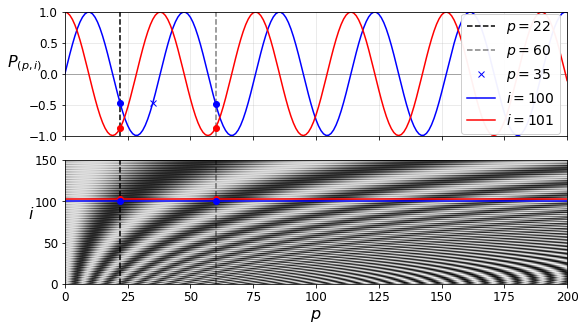

In [79]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()

Here, we can create the first layers of the Transformer:

In [80]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

If we ignore the skip connections, the layer normalization layers, the Feed Forward blocks, and the fact that this is Scaled Dot-Product Attention, not exactly Multi-Head Attention, then the rest of the Transformer model can be implemented like this:

In [81]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

The `use_scale=True` argument creates an additional parameter that lets the layer learn how to properly downscale the similarity scores. 

This is a bit different from the Transformer model, which always downscales the similarity scores by the same factor ( $\sqrt{d_{keys}}$). 

The `causal=True` argument when creating the second attention layer ensures that each output token only attends to previous output tokens, not future ones.

Here's a basic implementation of the `MultiHeadAttention` layer. One will likely be added to `keras.layers` in the near future. Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`) is equivalent to a `TimeDistributed(Dense(...))` layer.

In [82]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [83]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])

END.